# Техническая часть

In [1]:
!git clone https://github.com/DanilDmitriev1999/degree-project

Cloning into 'degree-project'...
remote: Enumerating objects: 18, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 18 (delta 2), reused 15 (delta 1), pack-reused 0
Unpacking objects: 100% (18/18), done.


In [2]:
!pip install transformers
!pip install seqeval

     |████████████████████████████████| 645kB 3.5MB/s 
     |████████████████████████████████| 890kB 9.9MB/s 
     |████████████████████████████████| 3.8MB 19.8MB/s 
     |████████████████████████████████| 1.1MB 32.3MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=f96d9d071eae30644831263c12ed29ec48c0731f4eb809910a52c70e8eaec925
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses
  Created wheel for seqeval: filename=seqeval-0.0.12-cp36-none-any.whl size=7424 sha256=e43ccf5dce20b3911f89a9152aa6f05e4a64ad021b285f00a73378d4cc955005
  Stored in directory: /root/.cache/pip/wheels/4f/32/0a/df3b340a82583566975377d65e724895b3fad101a3fb729f68
Successfully built seqeval


In [0]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import collections
from pprint import pprint
import seaborn as sns
import matplotlib.pyplot as plt

import math
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, RandomSampler, TensorDataset

from transformers import DistilBertModel, DistilBertTokenizer

from seqeval.metrics import f1_score, precision_score, recall_score, classification_report

np.random.seed(42)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# main

In [0]:
class Read_data:
    def __init__(self, path="degree-project/data"):
        entries = open(path, "r").read().strip().split("\n\n")

        self.sentence, self.label = [], []  # list of lists
        for entry in entries:
            words = [line.split()[0] for line in entry.splitlines()]
            tags = [self._check(line.split()[-1]) for line in entry.splitlines()]
            self.sentence.append(words)
            self.label.append(tags)

        self.sentence = [i for i in self.sentence if len(i) < 50 and len(i) > 5]
        self.label = [i for i in self.label if len(i) < 50 and len(i) > 5]


    def count_data(self, _chek_0=True):
        count_labels = collections.Counter()
        if _chek_0:
            train_label = [i for t in self.label for i in t]
        else:
            train_label = [i for t in self.label for i in t if i != 'O']
        for label in train_label:
           count_labels[label] += 1
        
        return count_labels

    def plot_count(self):
        count_labels = self.count_data(_chek_0=False)
        plt.figure(figsize=(15, 9))
        sns.set(style="darkgrid")

        x = list(count_labels.keys())
        y = list(count_labels.values())
        sns.barplot(x=x, y=y)

    def plot_len_data(self):
        plt.figure(figsize=(20, 6))
        len_sen = [len(i) for i in self.sentence]
        sns.distplot(len_sen);


    @staticmethod
    def _check(tag):
        if tag == 'B-Location':
            tag = 'B-Loc'
        if tag == 'I-Location':
            tag = 'I-Loc'
        if tag == 'I-Facility':
            tag = 'O'
        if tag == 'I-LocOrg':
            tag = 'I-Loc'
        if tag == 'B-LocOrg':
            tag = 'B-Loc' 
        return tag

    def __len__(self):
        return len(self.data)

    def __getitem__(self, i):
        return self.sentence[i], self.label[i]

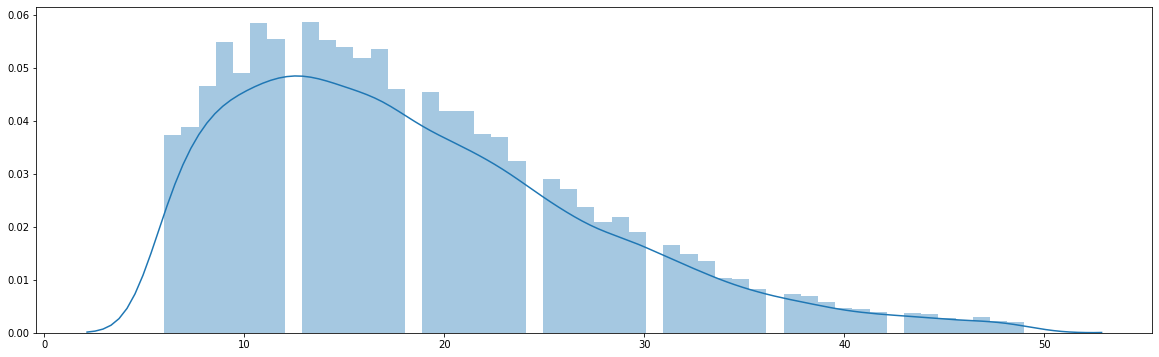

In [5]:
tr = Read_data('degree-project/data/train.txt')
tr.plot_len_data()

In [0]:
tr.count_data()

Counter({'B-Loc': 10813,
         'B-Org': 12756,
         'B-Person': 13619,
         'I-Loc': 2947,
         'I-Org': 10423,
         'I-Person': 12874,
         'O': 329220})

In [0]:
def convert_tokens_to_ids(tokens, pad=True):
    """Helper function
    """
    token_ids = tokenizer.convert_tokens_to_ids(tokens)
    ids = torch.LongTensor([token_ids])
    assert ids.size(1) < max_len, print(ids.size(1))
    if pad:
        padded_ids = torch.zeros(max_len).long()
        padded_ids[:ids.size(1)] = ids
        mask = torch.zeros(max_len).long()
        mask[0:ids.size(1)] = 1
        return padded_ids, mask
    else:
        return ids

def subword_tokenize(tokens, labels):
    """
    Helper function
    Segment each token into subwords while keeping track of
    token boundaries.
    Parameters
    ----------
    tokens: A sequence of strings, representing input tokens.
    Returns
    -------
    A tuple consisting of:
        - A list of subwords, flanked by the special symbols required
            by Bert (CLS and SEP).
        - An array of indices into the list of subwords, indicating
          that the corresponding subword is the start of a new
            token. For example, [1, 3, 4, 7] means that the subwords
            1, 3, 4, 7 are token starts, while all other subwords
            (0, 2, 5, 6, 8...) are in or at the end of tokens.
            This list allows selecting Bert hidden states that
            represent tokens, which is necessary in sequence
            labeling.
    """
    def flatten(list_of_lists):
        for list in list_of_lists:
            for item in list:
                yield item

    subwords = list(map(tokenizer.tokenize, tokens))
    subword_lengths = list(map(len, subwords))
    subwords = [CLS] + list(flatten(subwords)) + [SEP]
    token_start_idxs = 1 + np.cumsum([0] + subword_lengths[:-1])
    # X label described in Bert Paper section 4.3
    bert_labels = [[label] + (sublen-1) * ["X"] for sublen, label in zip(subword_lengths, labels)]
    bert_labels = ["O"] + list(flatten(bert_labels)) + ["O"]

    assert len(subwords) == len(bert_labels)
    assert len(subwords) <= 512
    return subwords, token_start_idxs, bert_labels


def subword_tokenize_to_ids(tokens, labels):
    assert len(tokens) == len(labels)
    subwords, token_start_idxs, bert_labels = subword_tokenize(tokens, labels)
    subword_ids, mask = convert_tokens_to_ids(subwords)
    token_starts = torch.zeros(max_len)
    token_starts[token_start_idxs] = 1
    bert_labels = [labels_to_ids[label] for label in bert_labels]
    # X label described in Bert Paper section 4.3 is used for pading
    padded_bert_labels = torch.ones(max_len).long() * labels_to_ids["X"]
    padded_bert_labels[:len(bert_labels)] = torch.LongTensor(bert_labels)

    mask.require_grad = False
    return {
        "input_ids": subword_ids,
        "attention_mask": mask,
        "bert_token_starts": token_starts,
        "labels": padded_bert_labels
    }

In [0]:
def prepare_dataset(path='degree-project/data/dev.txt'):
    dataset = Read_data(path)
    featurized_sentences = []
    for tokens, labels in dataset:
        features = subword_tokenize_to_ids(tokens, labels)
        featurized_sentences.append(features)

    def collate(featurized_sentences_batch):
        keys = ("input_ids", "attention_mask", "bert_token_starts", "labels")
        output = {key: torch.stack([fs[key] for fs in featurized_sentences_batch], dim=0) for key in keys}
        return output

    dataset = collate(featurized_sentences)
    return TensorDataset(*[dataset[k] for k in ("input_ids", "attention_mask", "labels")])

In [0]:
SEP = "[SEP]"
MASK = "[MASK]"
CLS = "[CLS]"
max_len = 150

LABELS = ['O', 'B-Person', 'I-Person', 'B-Org', 'I-Org', 'B-Loc', 'I-Loc', "X"]
ids_to_labels = {k:v for k, v in enumerate(LABELS)}
labels_to_ids = {v:k for k, v in enumerate(LABELS)}
num_labels = len(LABELS) - 1

In [0]:
#tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-multilingual-cased')

In [0]:
train_dataset = prepare_dataset('degree-project/data/train.txt')
val_dataset = prepare_dataset('degree-project/data/dev.txt')
batch_size= 16
sampler = RandomSampler(train_dataset)

train_dataloader= DataLoader(train_dataset, sampler=sampler, batch_size=batch_size, pin_memory=True)
val_dataloader= DataLoader(val_dataset, batch_size=batch_size, pin_memory=True)

# Model

In [0]:
class BERTNer(nn.Module):
    def __init__(self,
                 bert,
                 output_dim, 
                 dropout):
        
        super().__init__()
        
        self.bert = bert
        
        # embedding_dim = bert.config.to_dict()['hidden_size']
        
        self.fc = nn.Linear(768, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input_ids, attention_mask):
        sequence_output = self.bert.forward(
            input_ids=input_ids,
            attention_mask=attention_mask,
        )[0]

        sequence_output = self.dropout(sequence_output)
        logits = self.fc(sequence_output)
        
        return logits

In [0]:
def f1(outputs, verbose=False):
    #y_predict = torch.argmax(y_predict, dim = -1)
    y_true, y_pred = [], []
    for out in outputs:
    #print(outputs['y_pred'], outputs['y_true'])
        batch_pred = out['y_pred'].cpu().numpy().tolist()
        batch_y = out['y_true'].cpu().numpy().tolist()
        batch_seq = out['mask'].cpu().numpy().sum(-1).tolist()
        for i, length in enumerate(batch_seq):
            batch_pred[i] = batch_pred[i][:length]
            batch_y[i] = batch_y[i][:length]
        y_true += batch_y
        y_pred += batch_pred

    flatten = lambda l: [item for sublist in l for item in sublist]
    y_true = flatten(y_true)
    y_pred = flatten(y_pred)
    y_true = [ids_to_labels[l] for l in y_true]
    y_pred = [ids_to_labels[l] for l in y_pred]

    ids = [i for i, label in enumerate(y_true) if label != "X"]
    y_true_cleaned = [y_true[i] for i in ids]
    y_pred_cleaned = [y_pred[i] for i in ids]


    precision = precision_score(y_true_cleaned, y_pred_cleaned)
    recall = recall_score(y_true_cleaned, y_pred_cleaned)
    #repor = classification_report(y_true, y_pred)
    f1_s = f1_score(y_true_cleaned, y_pred_cleaned, average='Macro')

    #precision, recall, f1_s = evaluate(y_true_cleaned, y_pred_cleaned, verbose) #, verbose=False)

    return precision, recall, f1_s

In [0]:
def do_epoch(model, criterion, data, optimizer=None, name=None):
    epoch_loss = 0
    epoch_precision = 0
    epoch_recall = 0
    epoch_f1 = 0

    output = {
        'y_true': None,
        'y_pred': None,
        'mask': None,
              }

    outputs = []
    
    is_train = not optimizer is None
    name = name or ''
    model.train(is_train)
    
    batches_count = len(data)
    
    with torch.autograd.set_grad_enabled(is_train):
        with tqdm(total=batches_count) as progress_bar:
            for batch in data:
                text = batch[0].to(device)
                tags = batch[2].to(device)
                mask = batch[1].to(device)

                predictions = model(text, mask)

                X = labels_to_ids["X"]

                not_X_mask = tags != X
                active_loss = not_X_mask.view(-1)
                active_logits = predictions.view(-1, num_labels)
                active_labels = torch.where(
                        active_loss, tags.view(-1), torch.tensor(criterion.ignore_index).type_as(tags))
                loss = criterion(active_logits, active_labels)

                predict = torch.argmax(predictions, dim=-1)

                output.update({
                    'y_true': tags,
                    'y_pred': predict,
                    'mask': mask,
                })

                outputs.append(output)
                
                precision, recall, f1_s = f1(outputs)

                outputs = []

                epoch_loss += loss.item()
                epoch_precision += precision
                epoch_recall += recall
                epoch_f1 += f1_s

                if optimizer:
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                progress_bar.update()
                progress_bar.set_description('{:>5s} Average Loss = {:.5f}, Precision = {:.3%}, Recall = {:.3%}, F1-score = {:.3%}'.format(
                    name, epoch_loss / batches_count, precision, recall, f1_s))

            progress_bar.set_description('{:>5s} Average Loss = {:.5f}, Precision = {:.3%}, Recall = {:.3%}, F1-score = {:.3%}'.format(
                name, epoch_loss / batches_count, epoch_precision / batches_count, epoch_recall / batches_count, epoch_f1 / batches_count))

    return epoch_loss / batches_count


def fit(model, criterion, optimizer, train_data, epochs_count=1,
        val_data=None):
    for epoch in range(epochs_count):
        name_prefix = '[{} / {}] '.format(epoch + 1, epochs_count)
        train_loss = do_epoch(model, criterion, train_data, optimizer, name_prefix + 'Train:')
        
        if not val_data is None:
            val_loss = do_epoch(model, criterion, val_data, None, name_prefix + '  Val:')

In [20]:
#bert = BertModel.from_pretrained('bert-base-multilingual-cased')
bert = DistilBertModel.from_pretrained('distilbert-base-multilingual-cased')

OUTPUT_DIM = num_labels
DROPOUT = 0.1

model = BERTNer(bert, OUTPUT_DIM, DROPOUT).to(device)

In [21]:
LEARNING_RATE = 5e-5
optimizer = optim.Adam(model.parameters(), lr = LEARNING_RATE)
criterion = nn.CrossEntropyLoss().to(device)

fit(model, criterion, optimizer, train_data=train_dataloader,
    epochs_count=4, val_data=val_dataloader)

[1 / 4] Train: Average Loss = 0.14036, Precision = 78.435%, Recall = 78.867%, F1-score = 78.477%: 100%|██████████| 1323/1323 [09:33<00:00,  2.31it/s]
[1 / 4]   Val: Average Loss = 0.09471, Precision = 85.862%, Recall = 86.895%, F1-score = 86.330%: 100%|██████████| 189/189 [00:26<00:00,  7.03it/s]
[2 / 4] Train: Average Loss = 0.07448, Precision = 86.206%, Recall = 86.555%, F1-score = 86.311%: 100%|██████████| 1323/1323 [09:33<00:00,  2.31it/s]
[2 / 4]   Val: Average Loss = 0.06246, Precision = 89.194%, Recall = 90.481%, F1-score = 89.784%: 100%|██████████| 189/189 [00:26<00:00,  7.02it/s]
[3 / 4] Train: Average Loss = 0.04613, Precision = 90.261%, Recall = 90.783%, F1-score = 90.466%: 100%|██████████| 1323/1323 [09:28<00:00,  2.33it/s]
[3 / 4]   Val: Average Loss = 0.03957, Precision = 93.029%, Recall = 93.518%, F1-score = 93.253%: 100%|██████████| 189/189 [00:26<00:00,  7.18it/s]
[4 / 4] Train: Average Loss = 0.02945, Precision = 93.149%, Recall = 93.861%, F1-score = 93.468%: 100%|███